# Итоговая аттестация - АБ тестирование, Тервер, Продуктовая аналитика

## Кейс №1

Ваш продукт - это школа английского языка [Лендинг для языковой школы](https://english22.tilda.ws/). Проанализируйте конкурентов на рынке (SkyEng, Lingvoleo и прочие) и сформулируйте гипотезу по улучшению первого экрана лендинг.

Изучив сайт данной компании и сайты конкурентов, я бы хотел предложить следующие гипотезы для улучшения:

- Если добавить меню в header сайта для всех пользователей, то мы уменьшим показатель отказа на 1%, потому что пользователю будет удобнее, привычнее и проще найти необходимую информацию по предлагаемым услугам без дополнительного скролинга.

-  Если заменить изображение на более контрастное (изображение неприятно для глаз, слишком голубое, текст тяжело воспринимать), то мы уменьшим показатель отказа на 2%, потому что пользователю будет комфортнее воспринимать информацию.

- Если заменить текст "Оттачивайте английский с лучшими преподавателями и носителями языка – это комфортно и доступно." на  "Научим грамотно и уверенно говорить на любые темы, читать книги и свободно общаться за границей!", то мы увеличим конверсию в заказ на 3%, так как пользователь сразу понимает, что он приобретет, выбрав нашу школу. 

-  Если заменить текст "Учите английский онлайн" на  "Свободный английски за 5 месяцев", то мы увеличим конверсию в заказ на 1%, так как пользователь сразу понимает, что он получит и за какой период.

-  Если добавить название школы (графический.текстовый знак), то мы увеличим показатель удержания на 1%, так как пользователю будет легче запомнить нас запомнить и найти в будущем.

## Кейс №2 

Подведите результаты эксперимента по следующим данным: ab_stats.csv. Стат значимо ли отличается ARPPU в двух группах ? Какие рекомендации дадите менеджеру?

In [1]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind
from statsmodels.stats.power import TTestIndPower

In [2]:
df = pd.read_csv('ab_stats.csv')
df.head()

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814


Изначально проведем исследовательский данных EDA.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


В данных нет пропущенных значений, типы данных соотвествующие.

In [4]:
df.duplicated().sum()

3733

В данных есть дубликаты. Удалим их.

In [5]:
df.drop_duplicates(inplace=True)
df.shape

(19919, 5)

Посмотри как у нас распределились пользователи по группам:

In [6]:
df_group = df \
                .groupby('ab_group', as_index=False) \
                .agg({'num_purchases': 'count', 'revenue': 'sum'}) \
                .rename(columns={'num_purchases': 'number_of_users'})

df_group

,ab_group,number_of_users,revenue
0,A,9989,4786.807972
1,B,9930,2892.735789


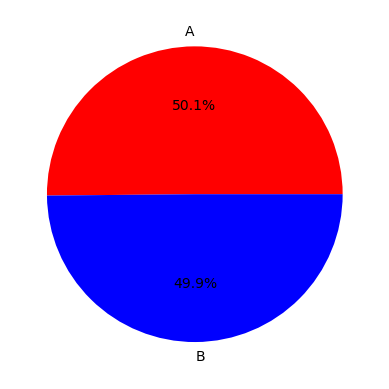

In [7]:
plt.pie(df_group.number_of_users, labels=df_group.ab_group, autopct='%.1f%%', colors=['red', 'blue']);

В каждой группе примерно равное количество пользователей. Но доход значительно отличается, возможно в группе A есть выбросы, либо контрольная версия более успешная.

Теперь рассмотрим более детально каждую группу. Так как нас интересует ARPPU (это метрика, которая показывает среднюю прибыль от одного платящего пользователя за определенный период времени), то мы сразу исключим данные, в которых доход равен 0.

In [2]:
df_A = df[(df.ab_group == 'A') & (df.revenue > 0)]
df_B = df[(df.ab_group == 'B') & (df.revenue > 0)]
df_A.head()

NameError: name 'df' is not defined

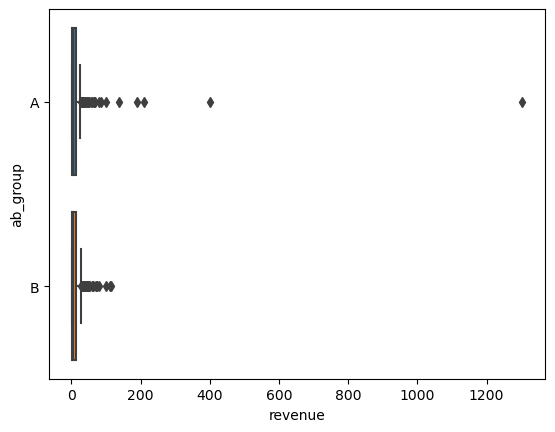

In [9]:
sns.boxplot(data=df.query('revenue > 0'), x='revenue', y='ab_group')
plt.show();

In [10]:
df_A.describe()

,revenue,num_purchases,purchase,av_site visit
count,256.000000,256.000000,256.0,256.000000
mean,18.698469,2.343750,1.0,6.753074
std,87.527589,9.723582,0.0,2.043753
min,0.259689,1.000000,1.0,0.996753
25%,2.318301,1.000000,1.0,5.281247
50%,4.283160,1.000000,1.0,6.871241
75%,11.923141,2.000000,1.0,8.257506
max,1303.609284,152.000000,1.0,12.504262


In [11]:
df_B.describe()

,revenue,num_purchases,purchase,av_site visit
count,234.000000,234.000000,234.0,234.000000
mean,12.362119,1.841880,1.0,6.844776
std,19.007065,2.354021,0.0,3.970112
min,0.259373,1.000000,1.0,-5.646523
25%,2.319883,1.000000,1.0,4.009016
50%,3.980000,1.000000,1.0,7.143956
75%,12.274829,2.000000,1.0,9.776519
max,113.830000,25.000000,1.0,16.955948


Из графика и описательной статистики очевидно, что в группе A есть существенные выбросы, возможно был пользователь, который совершил такое количество покупок, но данная ситуация атипична, поэтому для дальнейшего исследования необходимо исключить выборосы.

In [1]:
df_A_clean = df_A[df_A.revenue < df_A.revenue.quantile(0.975)]
df_A_clean.describe()

NameError: name 'df_A' is not defined

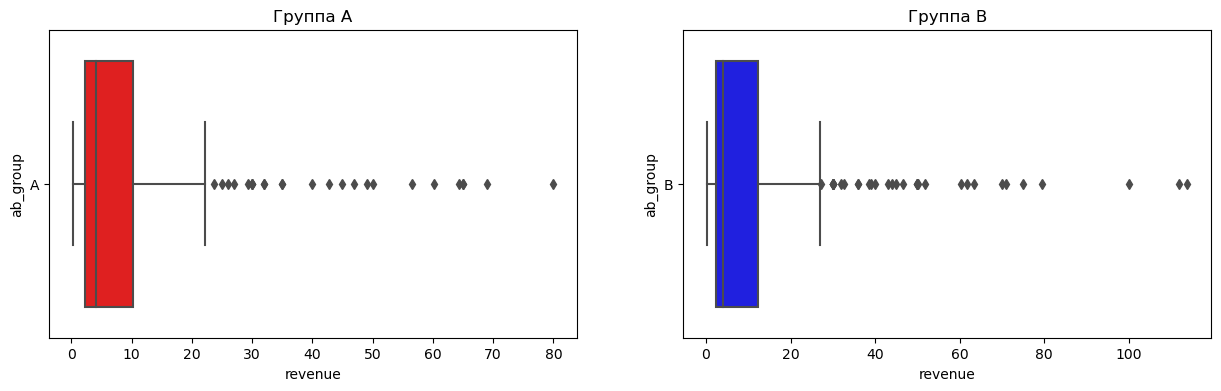

In [13]:
fig, (ax_boxplot, ay_boxplot) = plt.subplots(1, 2, figsize=(15, 4))


ax_boxplot.set_title('Группа А')
ay_boxplot.set_title('Группа B')
sns.boxplot(data=df_A_clean, x='revenue', y='ab_group', color='r', ax=ax_boxplot)
sns.boxplot(data=df_B, x='revenue', y='ab_group', color='b', ax=ay_boxplot);

In [14]:
print('ARPPU (среднее значение) в группах A и B соответственно:')
print(f"{df_A_clean['revenue'].mean():.4f}\n" 
      f"{df_B['revenue'].mean():.4f}")

ARPPU (среднее значение) в группах A и B соответственно:
9.4863
12.3621


In [15]:
print('Медиана в группах A и B соответственно:')
print(f"{df_A_clean['revenue'].median():.4f}\n" 
      f"{df_B['revenue'].median():.4f}")

Медиана в группах A и B соответственно:
4.0757
3.9800


Исключив существенные выбросы, мы получили достаточно близкие группы, выясним есть ли статистические значимые различия.

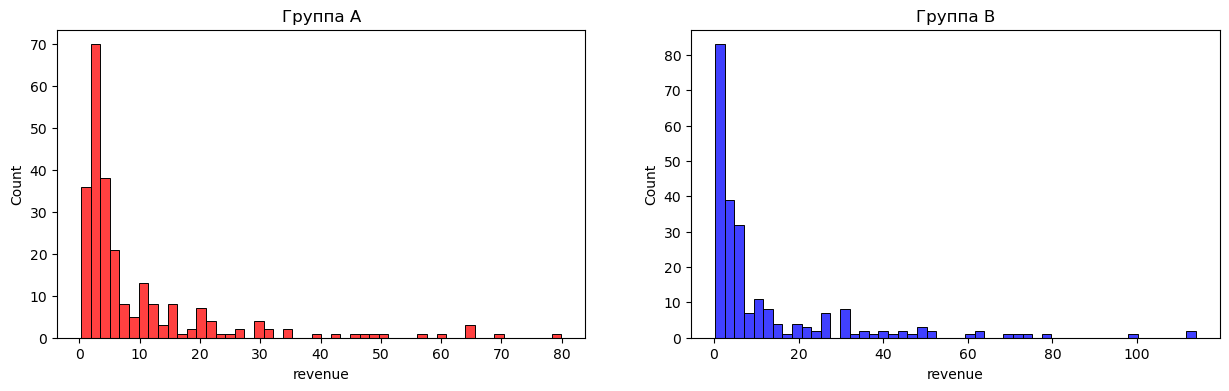

In [16]:
fig, (ax_histplot, ay_histplot) = plt.subplots(1, 2, figsize=(15, 4))

ax_histplot.set_title('Группа A')
ay_histplot.set_title('Группа В')
sns.histplot(df_A_clean['revenue'], bins=50, color='r', ax=ax_histplot)
sns.histplot(df_B['revenue'], bins=50, color='b', ax=ay_histplot);

In [17]:
df_A_clean.shape, df_B.shape

((249, 5), (234, 5))

Из графика очевидно, что данные распределения не нормальные. И размер выборки небольшой, для оценки статистически значимых различий применим критерий Манна-Уитни.

In [18]:
mannwhitneyu(df_A_clean.revenue.values, 
             df_B.revenue.values)

MannwhitneyuResult(statistic=28097.5, pvalue=0.49940952593129473)

p-value > 0.05 => нет статистически значимых различий, недостаточно оснований для отклонения нулевой гипотезы. 

Рассмотрим также метрику ARPU (показывает, сколько денег в среднем приносит компании один пользователь за определенный промежуток времени). Как правило эти метрики рассматривают совместно.

In [19]:
df_clean = df[df.num_purchases <= 25] # исключим существенные выбросы
df_clean.describe()

,revenue,num_purchases,purchase,av_site visit
count,19917.000000,19917.000000,19917.000000,19917.000000
mean,0.299960,0.042326,0.024502,7.016286
std,3.884460,0.398665,0.154604,3.140652
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.180160
50%,0.000000,0.000000,0.000000,7.006503
75%,0.000000,0.000000,0.000000,8.863318
max,208.303751,25.000000,1.000000,22.446822


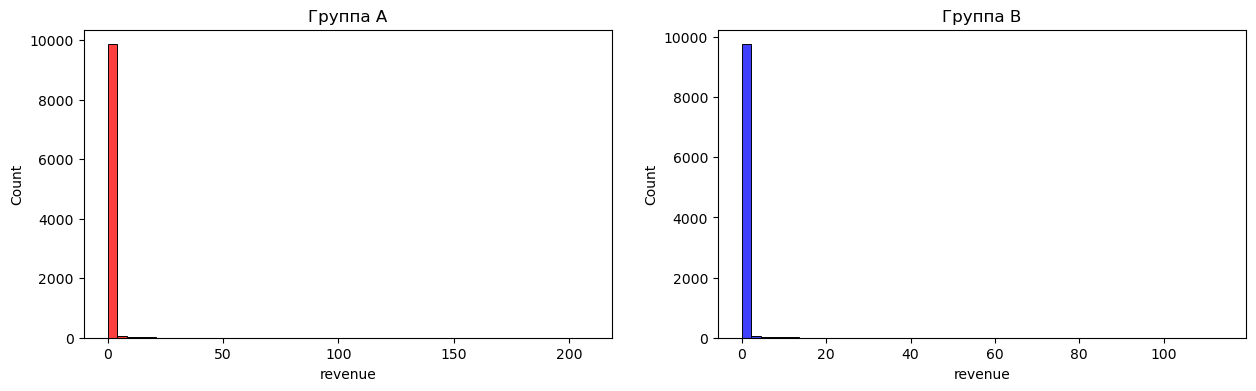

In [20]:
fig, (ax_histplot, ay_histplot) = plt.subplots(1, 2, figsize=(15, 4))

ax_histplot.set_title('Группа A')
ay_histplot.set_title('Группа В')
sns.histplot(df_clean.query('ab_group == "A"')['revenue'], bins=50, color='r', ax=ax_histplot)
sns.histplot(df_clean.query('ab_group == "B"')['revenue'], bins=50, color='b', ax=ay_histplot);

In [21]:
df_clean.query('ab_group == "A"').shape, df_clean.query('ab_group == "B"').shape

((9987, 5), (9930, 5))

Очевидно, что распределение не является нормальным, но у нас много наблюдений, поэтому рассмотрим тесты Манна-Уитни и критерий Стьюдента.

In [22]:
mannwhitneyu(df_clean.query('ab_group == "A"').revenue.values, 
             df_clean.query('ab_group == "B"').revenue.values)

MannwhitneyuResult(statistic=49677629.5, pvalue=0.3962510896528323)

In [23]:
ttest_ind(df_clean.query('ab_group == "A"').revenue.values, 
             df_clean.query('ab_group == "B"').revenue.values, equal_var = False)

Ttest_indResult(statistic=0.31342797331934313, pvalue=0.7539589469700184)

В результате расчета по обоим критериям pvalue > 0.05 => нет статистически значимых различий.

Расчитаем мощность нашего теста.

In [24]:
alpha = 0.05

C_mean = df_clean.query('ab_group == "A"')['revenue'].values.mean()
T_mean = df_clean.query('ab_group == "B"')['revenue'].values.mean()

C_std = df_clean.query('ab_group == "A"')['revenue'].values.std()
T_std = df_clean.query('ab_group == "B"')['revenue'].values.std()

S = np.sqrt((T_std**2 + C_std **2)/ 2)
effect_size =float((T_mean-C_mean)/ S)

n = df_clean.query('ab_group == "A"').shape[0]

analysis = TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, power=None, nobs1=n, ratio=1.0, alpha=alpha)
print(f'Мощность теста составляет: {result*100:.2f}%')

Мощность теста составляет: 6.14%


Мощность теста составляет 6.14%, что является критически низким для принятия верного решения, так как с таким значением мощности мы имеем очень низкую вероятность обнаружить статистически значимые различия. Для увеличения мощности необходимо увеличить размер выборки:

In [25]:
power = 0.8
N = analysis.solve_power(effect_size=effect_size, power=power, nobs1=None, ratio=1.0, alpha=alpha)
round(N), round(N/n)

(796036, 80)

## Выводы:

Таким образом, для A/B-теста по данным метрикам у нас недостаточно данных для обнаружения статистически значимых различий, если они действительно есть. Hеобходимо увеличить размер выборки для группы в 80 раз и повторить эксперимент. По полученным результатам у нас недостаточно оснований для отклонения нулевой гипотезы. Необходимо провести тест еще раз, значительно увеличив размер выборки.

## Кейс №3

Мы хотим провести А/Б-тест для трех источников трафика. Нынешняя конверсия равна 5%, мы ожидаем прирост в 0,2%.
Уровень доверия 97% и уровень мощности 87%.
Всего на наш продукт заходит 40 000 пользователей в месяц.

1) За сколько дней мы сможем протестировать гипотезу? И что вы можете посоветовать по результатам подсчета?

2) Допустим в задаче нет проблемы с количеством посетителей на сайт, тогда подведите результаты тестирования, если у нас следующие результаты по количеству конверсии:

    - 25 000
    - 30 000
    - 32 000

**РЕШЕНИЕ:**

1. Воспользуемя [калькулятор](https://mindbox.ru/tools/ab-test-calculator/) для расчета размера выборки

    <img src="3.1.jpg" alt="3.1" width=70%>

In [27]:
days = round(516_176 / 40_000)
print(f'Мы можем провести наш тест за {days} месяцев.')

Мы можем провести наш тест за 13 месяцев.


2. Воспользуемя [калькулятор](https://mindbox.ru/tools/ab-test-calculator/) для расчета

<img src="3.2.jpg" alt="3.2" width=70%>

## Кейс №4

Вы решили сравнивать метрику CPA в двух группах. Размер выборки - 2350 элементов в
каждой группе.

Для проверки нормальности распределения на выборке в 2350 наблюдений применили,
критерий Шапиро-Уилка и получили p-value, равный 0.00002, alpha = 5%.

Какой бы вывод мы могли сделать в данном случае?
В этом случае какой статистический критерий для проверки первоначальной гипотезы тут лучше
всего подойдёт и почему ?


**ОТВЕТ:** 

Условие применение критерия Шапиро-Уилка - размер выборки должен быть не более 2000! В нашем случае объем выборки 2350 наблюдений, таким образом данный тест не валидный, делать выводы о нормальности распределения по результатом этого теста не рекомендуется. Необходимо применить тест Колмагорова-Смирнова, также можно построить QQplot и гистограмму для анализа распределения на выборке. Если распределение нормальное, то для оценки статистичской значимости различий в группах можно применить критерий Стьюдента, иначе Манна-Уитни или применить метод бутстрап. 

## Кейс №5

Мы провели АБ-тест на увеличение average timespent per user. По итогам тестирования мы
получили следующие данные. 

Является ли результат статистически значимым с уровнем
доверия 80%? Какую версию мы выкатим на продакшн?

A) Средняя - 360, отклонение - 40, количество - 9802

B) Средняя - 352, отклонение - 58, количество - 9789


**РЕШЕНИЕ:**

Для решения воспользуемся [калькулятором](https://www.evanmiller.org/ab-testing/t-test.html)

<img src="5.jpg" alt="5" width=70%>

В результате расчета получили p-value значительно меньше заданного уровня (p < 0.001). Из графиков очевидно, что доверительные интервалы не пересекаются, таким образом статистически значимые различия есть. Группа А лучше => выкатываем в прдакшн.

## Кейс №6

Создайте техническую архитектуру проекта по аб тестированию продукта он-лайн кинотеатра с учетом кросс-девайс аналитики по следующей гипотезе:

Если договориться с банком о 99% кэшбэке на подписку первого месяца, то это повысит
конверсию в подписку на 30%, благодаря упрощенному принятию решения со стороны
пользователя.

На схеме необходимо отобразить:

1) Управленческий процесс по договоренностям с внешними партнерами

2) Архитектуру данных с указанием систем, из которых будем скачивать данные

3) Внутрикомандное взаимодействие

**ОТВЕТ:**

1) Управленческий процесс по договоренностям с внешними партнерами:
- Менеджер по взаимодействию с внешними партнерами согласовывает условия с банком для предоставления кэшбэка на подписку первого месяца.

2) Архитектура данных:
- Система управления клиентскими данными (CRM) для получения данных о клиентах и их активности на платформе.
- Аналитические инструменты для сбора и анализа данных о конверсии в подписку после внедрения кэшбэка (Яндекс Метрика, Google Analytics).
- Мобильные и веб-платформы для отслеживания активности пользователей на различных устройствах.
- Базы данных для хранения и обработки данных.

3) Внутрикомандное взаимодействие:
- Менеджер по маркетингу и продукту для разработки и внедрения новых маркетинговых акций и продуктовых улучшений на основе данных о конверсии и активности пользователей.
- Аналитики для анализа данных и внедрения изменений в продуктовую логику и интерфейс на основе результатов тестирования.
- Команда по внедрению (разаработчики, тестировщики) для технической реализации изменений в продукте и тестирования ПО.